# Calculate the Customer Life Time Value (CLTV) Using 2 Different methods

## 1. RFM Method

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("customer_purchases.csv")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
print("Total number of transactions happened in the given period: "+ str(data.shape[0]))
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = data[features]
data_clv['TotalSales'] = data_clv['Quantity'].multiply(data_clv['UnitPrice'])
data_clv['InvoiceDate'] = pd.to_datetime(data_clv['InvoiceDate'])
print(data_clv.shape)
data_clv.head()

Total number of transactions happened in the given period: 541909
(541909, 6)


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34


#### Aggregate Model 

In [5]:
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate': lambda x: (x.max() - x.min()).days,
                                              'InvoiceNo': lambda x: len(x),
                                              'TotalSales': lambda x: sum(x)})
customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
CustomerID,,,
12346.0,0,2,0.00
12347.0,365,182,4310.00
12348.0,282,31,1797.24
12349.0,0,73,1757.55
12350.0,0,17,334.40


In [6]:
# calculate the required variables for CLV calculation
Average_sales = round(np.mean(customer['TotalSales']),2)
print(f"Average sales: ${Average_sales}")
Purchase_freq = round(np.mean(customer['Frequency']), 2)
print(f"Purchase Frequency: {Purchase_freq}")
Retention_rate = customer[customer['Frequency']>1].shape[0]/customer.shape[0]
churn = round(1 - Retention_rate, 2)
print(f"Churn: {churn}%")

Average sales: $1898.46
Purchase Frequency: 93.05
Churn: 0.02%


In [7]:
# Calculating the CLV
Profit_margin = 0.05
CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
print(f"The Customer Lifetime Vlaue for each customer is: ${CLV}")

The Customer Lifetime Vlaue for each customer is: $441629.26


In [8]:
customer['TotalSales'].describe()

count      4372.000000
mean       1898.459701
std        8219.345141
min       -4287.630000
25%         293.362500
50%         648.075000
75%        1611.725000
max      279489.020000
Name: TotalSales, dtype: float64

#### Cohort Model

In [9]:
data_clv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   406829 non-null  float64       
 1   InvoiceNo    541909 non-null  object        
 2   InvoiceDate  541909 non-null  datetime64[ns]
 3   Quantity     541909 non-null  int64         
 4   UnitPrice    541909 non-null  float64       
 5   TotalSales   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 24.8+ MB


In [10]:
#Trasforming the data to customer level for the analysis
customer = data_clv.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month,
                                              'InvoiceNo': lambda x: len(x),
                                              'TotalSales': lambda x: np.sum(x)})
customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
CustomerID,,,
12346.0,1,2,0.00
12347.0,12,182,4310.00
12348.0,12,31,1797.24
12349.0,11,73,1757.55
12350.0,2,17,334.40


In [11]:
#Caluculating CLV for each cohurt
months = ['Jan','Feb','March','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Monthly_CLV = []
Profit_margin = 0.05
for i in range(1,13):
    customer_m = customer[customer['Start_Month']==i]
    Average_sales = round(np.mean(customer_m['TotalSales']),2)
    Purchase_freq = round(np.mean(customer_m['Frequency']),2)
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate,2) 
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
    Monthly_CLV.append(CLV)

In [12]:
MonthlyCLV = pd.DataFrame(
    {'Month': months,
     'CLV': Monthly_CLV
    })

In [13]:
MonthlyCLV

,Month,CLV
0,Jan,1385441.30
1,Feb,287038.75
2,March,516463.09
3,Apr,351523.91
4,May,90848.42
5,Jun,276937.02
6,Jul,49304.18
7,Aug,214112.48
8,Sep,184419.13
9,Oct,136841.11


## 2. Predictive Modelling 

In [14]:
import lifetimes

In [15]:
#pip install Lifetimes

In [16]:
#creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'CustomerID','InvoiceDate','TotalSales')
summary = summary.reset_index()
summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


count    2796.000000
mean        5.256795
std         7.754960
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       145.000000
Name: frequency, dtype: float64
Percentage of customers purchase the item only once: 0.0 %


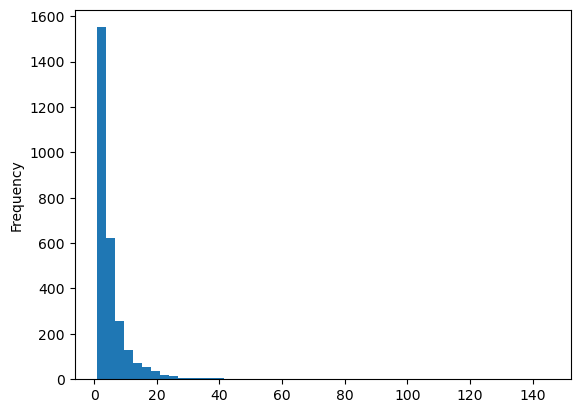

In [34]:
#create a distribution of freqeuncy to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers, "%")

In [18]:
#Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4372 subjects, a: 0.02, alpha: 55.62, b: 0.49, r: 0.84>

In [19]:
# Model Summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.843025,0.026206,0.791661,0.894389
alpha,55.619383,2.088118,51.526671,59.712095
a,0.021519,0.006381,0.009012,0.034026
b,0.488673,0.176970,0.141812,0.835534


In [20]:
# Compute the customer alive probability
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,325.0,0.000000,1.000000
1,12347.0,6.0,365.0,367.0,599.701667,0.995966
2,12348.0,3.0,283.0,358.0,301.480000,0.981687
3,12349.0,0.0,0.0,18.0,0.000000,1.000000
4,12350.0,0.0,0.0,310.0,0.000000,1.000000
5,12352.0,6.0,260.0,296.0,208.151667,0.991857
6,12353.0,0.0,0.0,204.0,0.000000,1.000000
7,12354.0,0.0,0.0,232.0,0.000000,1.000000
8,12355.0,0.0,0.0,214.0,0.000000,1.000000
9,12356.0,2.0,303.0,325.0,269.905000,0.983167


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

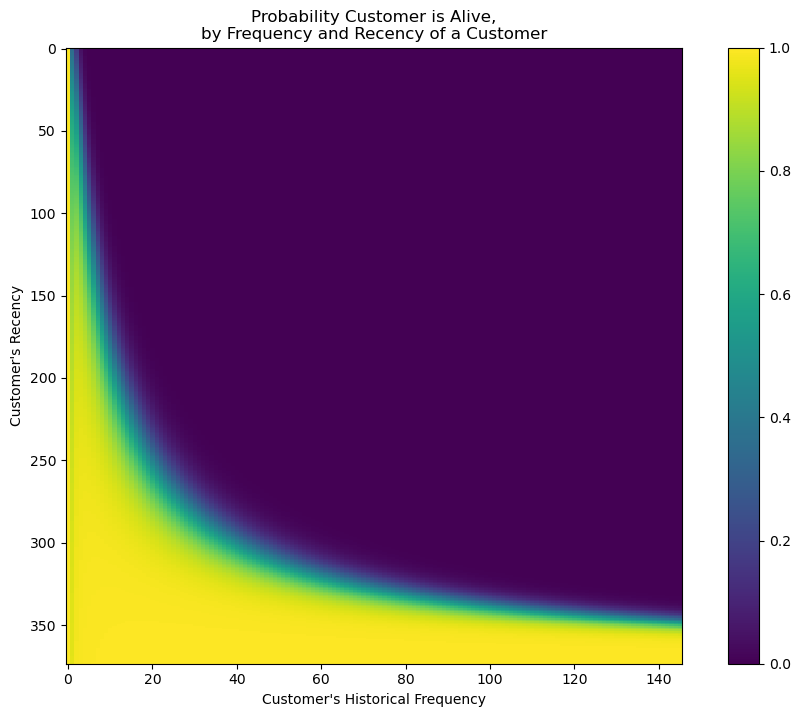

In [21]:
#Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [22]:
t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']))
top_10_customers = summary.sort_values(by='pred_num_txn', ascending=False).head(10)
top_10_customers.reset_index(inplace=True)
top_10_customers

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1895,14911.0,145.0,372.0,373.0,910.463724,0.999791,10.0
1,4042,17841.0,112.0,372.0,373.0,355.421429,0.999749,8.0
2,330,12748.0,114.0,373.0,373.0,254.975000,0.999810,8.0
3,2192,15311.0,90.0,373.0,373.0,655.266778,0.999760,6.0
4,568,13089.0,82.0,367.0,369.0,690.871707,0.999610,6.0
5,1674,14606.0,88.0,372.0,373.0,130.858295,0.999697,6.0
6,487,12971.0,71.0,369.0,372.0,153.311831,0.999494,5.0
7,3014,16422.0,66.0,352.0,369.0,486.931667,0.994981,5.0
8,803,13408.0,54.0,372.0,373.0,490.050556,0.999543,4.0
9,2099,15189.0,45.0,331.0,332.0,341.859111,0.999456,4.0


In [23]:
#checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary.head()

(2991, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
1,12347.0,6.0,365.0,367.0,599.701667,0.995966,0.0
2,12348.0,3.0,283.0,358.0,301.480000,0.981687,0.0
5,12352.0,6.0,260.0,296.0,208.151667,0.991857,1.0
9,12356.0,2.0,303.0,325.0,269.905000,0.983167,0.0
11,12358.0,1.0,149.0,150.0,683.200000,0.957457,0.0


In [24]:
#checking the relationship between frequency and monetary_value
return_customers_summary[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.198027
monetary_value,0.198027,1.000000


In [25]:
non_positive_values = return_customers_summary[return_customers_summary['monetary_value'] <= 0]
non_positive_values

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
51,12410.0,1.0,7.0,308.0,-12.25,0.470237,0.0
89,12454.0,1.0,3.0,56.0,-3528.34,0.873888,0.0
108,12479.0,2.0,8.0,11.0,-24.95,0.983789,1.0
123,12501.0,1.0,21.0,336.0,-79.71,0.528958,0.0
126,12504.0,2.0,12.0,30.0,-167.70,0.972500,1.0
...,...,...,...,...,...,...,...
4321,18220.0,1.0,7.0,226.0,-7.50,0.587052,0.0
4346,18250.0,1.0,9.0,310.0,-6.35,0.482168,0.0
4359,18269.0,1.0,8.0,366.0,-29.70,0.410293,0.0
4363,18274.0,1.0,13.0,30.0,-175.92,0.937895,1.0


In [26]:
# Remove rows with non-positive monetary values
return_customers_summary = return_customers_summary[return_customers_summary['monetary_value'] > 0]

# Fit the Gamma-Gamma model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2796 subjects, p: 10.68, q: 0.89, v: 10.82>

In [27]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,10.677650,0.263545,10.161102,11.194198
q,0.891746,0.021077,0.850435,0.933057
v,10.824818,0.276199,10.283467,11.366169


In [28]:
summary = summary[summary['monetary_value']>0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                                                  summary['monetary_value'])
summary.sort_values(by='pred_num_txn', ascending=False).head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
1895,14911.0,145.0,372.0,373.0,910.463724,0.999791,10.0,910.602047
4042,17841.0,112.0,372.0,373.0,355.421429,0.999749,8.0,355.550264
330,12748.0,114.0,373.0,373.0,254.975000,0.999810,8.0,255.092641
568,13089.0,82.0,367.0,369.0,690.871707,0.999610,6.0,691.089163
1674,14606.0,88.0,372.0,373.0,130.858295,0.999697,6.0,130.996397


In [29]:
#checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 345.535641033724
Actual Average Sales: 339.2490770584033


In [30]:
# predicting customer lifetime value for the next 30 days
summary["predicted_clv"] = ggf.customer_lifetime_value(bgf,
                                                      summary['frequency'],
                                                      summary['recency'],
                                                      summary['T'],
                                                      summary['monetary_value'],
                                                      time=1,
                                                      freq='D',
                                                      discount_rate=0.01)
summary.sort_values(by='pred_num_txn', ascending=False).head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
1895,14911.0,145.0,372.0,373.0,910.463724,0.999791,10.0,910.602047,9194.517107
4042,17841.0,112.0,372.0,373.0,355.421429,0.999749,8.0,355.550264,2777.610567
330,12748.0,114.0,373.0,373.0,254.975000,0.999810,8.0,255.092641,2028.266419
568,13089.0,82.0,367.0,369.0,690.871707,0.999610,6.0,691.089163,4000.302797
1674,14606.0,88.0,372.0,373.0,130.858295,0.999697,6.0,130.996397,805.665878


In [31]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.sort_values(by='pred_num_txn', ascending=False).head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
1895,14911.0,145.0,372.0,373.0,910.463724,0.999791,10.0,910.602047,9194.517107,9106.020472
4042,17841.0,112.0,372.0,373.0,355.421429,0.999749,8.0,355.550264,2777.610567,2844.402109
330,12748.0,114.0,373.0,373.0,254.975000,0.999810,8.0,255.092641,2028.266419,2040.741126
568,13089.0,82.0,367.0,369.0,690.871707,0.999610,6.0,691.089163,4000.302797,4146.534976
1674,14606.0,88.0,372.0,373.0,130.858295,0.999697,6.0,130.996397,805.665878,785.978380


In [32]:
profit_margin = 0.05
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,CLV
1,12347.0,6.0,365.0,367.0,599.701667,0.995966,0.0,602.523905,288.355789,0.000000,14.417789
2,12348.0,3.0,283.0,358.0,301.480000,0.981687,0.0,306.122802,82.849065,0.000000,4.142453
5,12352.0,6.0,260.0,296.0,208.151667,0.991857,1.0,210.311172,120.454081,210.311172,6.022704
9,12356.0,2.0,303.0,325.0,269.905000,0.983167,0.0,276.720155,60.285564,0.000000,3.014278
11,12358.0,1.0,149.0,150.0,683.200000,0.957457,0.0,701.133169,178.233939,0.000000,8.911697


In [33]:
summary['CLV'].describe()

count    2796.000000
mean       11.251513
std        37.207960
min         0.019150
25%         2.575258
50%         5.324956
75%        10.804773
max      1030.551557
Name: CLV, dtype: float64